# Kombination von FastAI v2 mit HuggingFace via Blurr.

Interessant, da für Huggingface Tools wie der LR-Finder von FastAI verwendet werden können. Im Endeffekt sind die Ergebnisse ohne gesondertes Pre-Processing aber ähnlich. Mit mehr Know-How bei FastAI könnte es allerdings hilfreich sein.

In [ ]:
# !pip install fastai --upgrade
# !pip install transformers --upgrade
# !pip install ohmeow-blurr

In [1]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.text.all import *
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
import os
from transformers import *
from blurr.data.all import *
from blurr.modeling.all import *
import json

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Magnus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
torch.cuda.set_device(0)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #0: GeForce RTX 3060 Ti


In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
df=pd.read_csv("data/train_500.csv")
df2=pd.read_csv("data/train_100.csv")

df=df.drop(["Unnamed: 0"],axis=1)
df=df.rename({"Narrative":"text","Abteilung":"label"},axis=1)
mask = np.ones(df.shape[0], np.bool)
trainSplit = np.array(random.sample(range(df.shape[0]),round(0.8*df.shape[0])))
mask[trainSplit] = 0
validSplit=np.arange(df.shape[0])[mask]
df_train=df.iloc[trainSplit,:]
df_valid=df.iloc[validSplit,:]
df.loc[trainSplit,"is_valid"]=False
df.loc[validSplit,"is_valid"]=True
df.head(5)

,text,label,is_valid
0,"Sehr geehrtes Helpdeskteam, ich habe mir gestern Power 6 gekauft und wollte heute mit dem Programm einen Iso-Prozess (Benefizverkauf unseres Partners) auf DVD brennen. Das hat wohl geklappt, aber es ist wieder ein sfc-Datei entstanden. Ihr Programm konvertiert also nicht auf data. Nun habe ich schon viele registrierte Software von WAREHOUSE. Auf eine weitere kommt´s jetzt auch nicht mehr drauf an: welches Konvertierungsprogramm fehlt mir? Mit freundlichen Grüßen Werner Würzmann Altenburg",2,False
1,"Ich habe das Produkt registriert, kann das programm aber nicht starten. Es bricht jedesmal ab. Als erstes erscheint die Registrierungsabfrage. Sie wird mit bereits registriert angezeigt. wenn ich ""starten"" drücke bricht alles ab. Warum muß ich das produkt überhaupt registrieren, wenn ich eine gültige Seriennummer habe? Die dabei anzugebenden Fragen sind meine persönlichen Daten, die niemanden etzwas angehen.",6,False
2,"Ich habe mein Verkaufsmaterial von einer MiniDVD importiert und in den Coordinator geschoben.Wenn ich den Ablauf von Anfang an durchrechne funtioniert alles.Wenn ich jedoch den Anzeigepfeil weiter versetze ist keine Artikelbestellnummer zu sehen. Es wird auch oft von einer anderen Stelle des Ablaufes die Bestellnummer angezeigt.Vermutlich habe ich beim Programm eine falsche Konfiguration gewählt.Ich hoffe sie können mir einige Tipps geben,so daß mein Import wieder funktioniert.Ich danke ihnen im Voraus.",3,False
3,Sehr geehrte Damen und und Herren Wie kann ich diese Software Version auf einen Windows 7 PC installieren? Freundliche Gruesse,4,False
4,"Habe mehrmals versucht meine Produktpreview zu brennen bei dem Disc Image kommt jedesmal Fehler. Problem in Klasse ""wmembank.dll"" (Ladeadresse:7X0f4d0124) an Adresse Ox6ffcre Exception 6Xd3382563 ACCESS_FORBIDDEN. Habe Fehlerprotokoll auch gesendet. Habe das programm neu und 1. mal versucht zu brennen. verschlüsselung läuft ca. 2 Std. Ist mir bei meiner Vorversion Warehouse 12 nicht passiert. habe Produkte,Prozesse und Statistiken verwendet.",5,False


In [5]:
model_path = Path('models')
task = HF_TASKS_AUTO.SequenceClassification

# tokenizer = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")
# model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased-finetuned-mrpc")

pretrained_model_name = "bert-base-german-cased"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name,  task=task,config_kwargs={'num_labels': 6}) 

In [6]:
blocks = (HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), CategoryBlock)
dblock = DataBlock(blocks=blocks,  get_x=ColReader('text'), get_y=ColReader('label'), splitter=ColSplitter())

dls = dblock.dataloaders(df, bs=4,num_workers=0)

In [7]:
dls.show_batch(dataloaders=dls, max_n=1)

,text,category
0,"Nachtrag zu d. bereits geschlossenen Ticket # : 1633443022242217 : Hallo Herr Krempler, zuerst einmal wünsche ich Ihnen frohe Festtage gehabt zu haben und alles Gute und hauptsächlich Gesundheit für das neue Jahr! Leider muss ich mich noch einmal an Sie wenden, da ich weiterhin Probleme habe überhaupt die Abläufe zu laden. Ich habe mehrfach versucht, die Treiberversion gemäß Ihren Erklärungen zu laden. Ich habe ein Jiaoda - Notebook N 25 L - Speicherkapazität 2. 048 - Betriebssystem Windows XP Also : - zuerst abgewartet, daß Updates für die Schutzprogramme abgeschlossen waren - den USB - Stick ohne weitere Verlängerungskabel an der Rückseite des Notebook eingesteckt ( welche Funktion hat der Knopf auf d. USB - Sick??? ) - die Treiberversion http : / / download. warehouse. net / warehouse _ usb - prozessverwalter _ 5 _ ( gelb _ weiss ) _ de - 4. zip auf den Desktop gespeichert. - dann ins Laufwerk C extrahiert. - dann setup. exe versucht auszuführen. Und hier beginnt das Problem : ich habe mit der rechten Mousetaste die EXE - Datei angeklickt, = > ausführen als angewählt, aber was ist mit Administrator gemeint? hier kommt immer die Frage : welches Benutzerkonto verwendet werden soll? Ich habe aktueller Benutzer ( Notebook Hanfke ) angeklickt + OK. Dann kommt immer der Hinweis : Error saving at the current location. Nach einigen Versuchen die Software herunterzuladen war ich sicher, daß es funktioniert hatte, es kam keine Fehlermeldung. Ausserdem war es bei Systemsteuerung / Software in der Liste enthalten, also dachte ich, das jetzt alles o. k. ist. - jetzt habe ich probiert, ob ich vom Datenscanner ( Powerread / Mini EM ` s ) einen Ablauf importieren kann. Also Datenscanner mit dem Verbindungskabel verbunden siehe Abbildung 1 = = > Frage : was ist mit dem übriggebliebenen Stecker? Jetzt im Programm Warehouse Sales firstclass WH den blauen Button gedrückt = = > als Erstellungsquelle oben rechts EM - Kartenleser ausgewählt. Jetzt kam der Hinweis, daß keine Verbindung zum Datenscan",4


In [8]:
b = dls.one_batch()
b = dls.one_batch(); len(b), len(b[0]['input_ids']), b[0]['input_ids'].shape, len(b[1]) 

(2, 4, torch.Size([4, 512]), 4)

In [9]:
model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam, decouple_wd=True), 
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter).to_fp16()

learn.create_opt() 
learn.freeze()

In [10]:
learn.fit_one_cycle(5, lr_max=2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.769162,1.634355,0.370000,00:06


KeyboardInterrupt: 

SuggestedLRs(lr_min=2.7542287716642023e-05, lr_steep=6.309573450380412e-07)

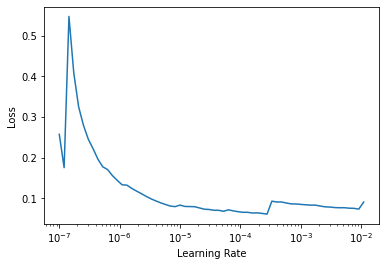

In [ ]:
learn.lr_find(suggestions=True)

In [ ]:
learn.save("tempGermanBERT")
# learn.load("tempGermanBERT")

Path('models/tempGermanBERT.pth')

In [ ]:
factor = 2.6
lr = 2e-5
lrs = [lr / (factor ** (4 - x)) for x in range(4)] + [lr]

In [ ]:
learn.unfreeze()
learn.fit(20, lr)